# 3 - Clustering: Algoritmo de las K-medias

Los algoritmos de **clustering** son el principal ejemplo de problemas de **aprendizaje no supervisado**. Estos consisten en buscar patrones dentro de los datos. Esto es, encontrar subconjuntos de observaciones que son similares entre sí. Por ejemplo, puede utilizarse para buscar grupos de clientes basados en su comportamiento, productos similares en base a sus características, tipos de películas en base a su audiencia, etc. Si se realiza un análisis cluster sobre los clientes de una determinada empresa se puede encontrar patrones de clientes y con ellos ofrecer productos especialmente diseñadas para estos segmentos.

# Montar directorio de Google Drive

In [ ]:
## Solicitar acceso y montar en el sistema tu directorio de Google Drive
# Esto permitirá la persistencia de datos entre distintas sesiones
import os, sys
from google.colab import drive
drive.mount('/content/drive')

# Creamos un directorio para este cuaderno y lo asociamos
drive_path = '/content/drive/MyDrive/Colab Notebooks/iabd-sbd'
nb_path = '/content/iabd-sbd'

if not os.path.exists(drive_path):
    os.makedirs(drive_path)
os.symlink(drive_path, nb_path)
sys.path.insert(0,nb_path)

%cd $nb_path

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/iabd-sbd


# Instalación de spark en Google Colab

In [ ]:
# Spark está escrito en el lenguaje de programación Scala, por lo que requiere
# de una máquina virtual de Java (JVM) para funcionar. Por lo tanto, lo primero
# es instalar java:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
## Instalación de Apache Spark en Google Colab (Ejecutar solo si no se ha realizado nunca)
# Nota: Puede tardar unos minutos (se paciente)
# El siguiente paso es elegir una versión reciente de spark
# En este notebook, se usará spark versión 3.1.2, la cual puede descargarse en:
spark_file = 'spark-3.3.2-bin-hadoop3.tgz'
spark_url = 'https://archive.apache.org/dist/spark/spark-3.3.2/' + spark_file

# A continuación, descargamos la versión elegida de spark:
import os # Libreria de manejo del sistema operativo
os.system("wget -q {spark_url} -P " + nb_path) # Realizamos la descarga
os.system("tar xf " + nb_path + "/" + spark_file) # Descomprimimos el fichero .tgz

# Realizamos la instalación de pyspark utilizando la herramienta pip
!pip install --target=$nb_path -q pyspark
!pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 17.3 MB/s eta 0:00:00


In [ ]:
# Damos permisos de ejecución
!chmod -R +x ./pyspark/

# Finalmente, es necesario definir algunas variables de entorno en el sistema
# operativo para poder usar spark correctamente:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = nb_path + "/pyspark"

## 3.1 K-means con datos simulados

En un primer ejemplo, veremos como podemos ejecutar el algoritmo K-means utilizando un dataset simulado. Este dataset se encuentra en el fichero 'datos_cluster.csv'. Este fichero contiene un dataset con tres muestras aleatorias de normales bivariantes (de dos variables) de tamaño $n=100$ cada uno. Cada una de estas normales se encuentra centrada en un punto diferente del espacio. Mas concretamente en: (1.5, 1.5), (-1.5, -1.5) y (2, -2).

In [ ]:
# Descargar el dataset que se utilizará utilizando un enlace compartido de google drive
# El fichero puede descargarse directamente de la fuente proporcionada, o se
# puede utilizar el siguiente código para descargarlo de google drive:
# URL: https://drive.google.com/file/d/1nxy20hBRuedmeculSu8K69j56PHCpU55
!gdown --id 1nxy20hBRuedmeculSu8K69j56PHCpU55

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1nxy20hBRuedmeculSu8K69j56PHCpU55
To: /content/drive/MyDrive/Colab Notebooks/iabd-sbd/datos_cluster.csv
100% 11.5k/11.5k [00:00<00:00, 44.5MB/s]


In [ ]:
# Importar pyspark.sql
from pyspark.sql import*

# Importar SparkContext and SparkConf
from pyspark import SparkContext, SparkConf

In [ ]:
# Establecer las propiedades de Spark:
# - URL de conexión
# - Nombre de la aplicación
conf = SparkConf().setMaster("local").setAppName("3-Clustering-K-means")

# Iniciar un cluster de Spark (puede tardar unos minutos)
# Comprobar si ya existe este cluster y en el caso contrario crear uno nuevo
sc = SparkContext.getOrCreate(conf=conf)

# Mostramos el cluster creado
sc

<SparkContext master=local appName=3-Clustering-K-means>

In [ ]:
!ls -la

total 2886
drwx------  2 root root    4096 May  9 17:55  bin
-rw-------  1 root root   11528 May 15 15:30  datos_cluster.csv
-rw-------  1 root root 2902908 May 15 14:38  listings.csv
drwx------  4 root root    4096 May  9 17:55  py4j
drwx------  2 root root    4096 May  9 17:55  py4j-0.10.9.7.dist-info
drwx------ 18 root root    4096 May  9 17:55  pyspark
drwx------  2 root root    4096 May  9 17:55  pyspark-3.4.0.dist-info
drwx------  2 root root    4096 May  9 17:55  share
-rw-------  1 root root   15021 May 15 14:40 'Wholesale customers data (1).csv'


In [ ]:
# Inicializar SQLContext a partir del cluster Spark creado anteriormente
sqlContext = SQLContext(sc)

# Creamos un dataframe a partir del archivo CSV descargado anteriormente y
# que contiene el dataset que utilizaremos en esta sesión
df = sqlContext.read.csv('datos_cluster.csv', header=True, sep=",", inferSchema = "true")

# Eliminamos las columnas channel y region (no aportan información relevante en este ejemplo)
df = df.drop("channel", "region")

# Mostrar el contenido del dataframe
df.show()

/content/iabd-sbd/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+-------------------+
|                  x1|                 x2|
+--------------------+-------------------+
|   1.017906861164521|  1.589587612589516|
|  1.6916185466351603| -1.751832975226213|
|  1.1090178146935965| 2.7551737317095712|
|   2.033884809310875| 2.2439744037859244|
|    1.85347761380385| 1.2927205142785623|
|  -1.336095747321568|-0.6704875156027585|
|  -2.074917664052446|-1.8601711344294525|
|  1.2058940126722866| -3.545873178823035|
|   2.844549423365941| 1.9935153172482887|
|  3.1182555086614974|-2.9002665799372958|
| -3.1919679287768083|-0.8835490775951268|
| -2.5247529670452837|-1.3396008370574413|
|  1.9400409054944103|-3.4174211585487924|
|  2.0037684355671863| -2.882372848092867|
| -1.0883975879371572|-1.2121895657052717|
|   2.737056344944984|-3.4583097774220137|
|   2.839926309957553| 1.5293097109431697|
|  1.8800750835243119|-3.0282624498459576|
|  2.5174066698301694|-3.5388014512157326|
|-0.47772828065790707|-0.2433722958989073|
+----------

A continuación, utilizaremos el *VectorAssembler* para generar una nueva columna en el dataframe la cual tendrá un vector del tipo DenseVector conteniendo todas las características del dataset. Recordad que este era un paso necesario antes de aplicar cualquier algoritmo de ML de la biblioteca [MLlib de Spark](https://spark.apache.org/docs/latest/ml-guide.html).

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
  inputCols = df.columns,
  outputCol = "features"
)
df = assembler.transform(df)

# Mostramos la nueva columa "features" para las 5 primeras filas del dataset
df.select("features").show(5, truncate=False)

+---------------------------------------+
|features                               |
+---------------------------------------+
|[1.017906861164521,1.589587612589516]  |
|[1.6916185466351603,-1.751832975226213]|
|[1.1090178146935965,2.7551737317095712]|
|[2.033884809310875,2.2439744037859244] |
|[1.85347761380385,1.2927205142785623]  |
+---------------------------------------+
only showing top 5 rows



Si las distintas variables del dataset que utilizaremos para entrenar el K-means son incomparables (por ejemplo, la altura en cm y el peso en kg), entonces se deben estandarizar las variables. Notar que este no es el caso en el dataset del ejemplo. No obstante, vamos a escalar las variables para que el lector pueda ver como se haría este proceso.

El escalado que aplicaremos será una estandarízación de desviación estándar la unidad. El motivo de aplicar una estandarización para igualar la desviación estándar es que el algoritmo K-means es "isotrópico" en todas las direcciones del espacio y por lo tanto tiende a producir clusters más o menos redondos (en lugar de alargados). En esta situación, dejar las varianzas desiguales equivale a dar más peso a las variables con menor varianza, por lo que los clusters tenderán a separarse a lo largo de las variables.

In [ ]:
# Aplicamos el standard Scaler
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='features',outputCol='standardized')
fit_scaler = scaler.fit(df)
df = fit_scaler.transform(df)

# Mostramos la nueva columa "standardized" para las 5 primeras filas del dataset
df.select("standardized").show(5, truncate=False)

+----------------------------------------+
|standardized                            |
+----------------------------------------+
|[0.5753973526412641,0.7666830109004377] |
|[0.9562297598615106,-0.8449364913287969]|
|[0.626900101524669,1.3288634583278962]  |
|[1.1497043388782198,1.0823040130990096] |
|[1.0477246522756367,0.6234993581293004] |
+----------------------------------------+
only showing top 5 rows



Ahora si, aplicamos el algoritmo K-means. Previamente se deben determinar algunos hipeparámetros, cómo K (el número de grupos) o initSteps (número de inicializaciones de los centroides). No obstante, este proceso requiere conocimientos más avanzados que se estudian en el módulo de Sistemas de Aprendizaje Automático, y que por lo tanto no se estudiarán en esta unidad.

Para más información sobre la implementación de PySpark sobre el algoritmo K-means puede consultar la [documentación de la API](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.KMeans.html).

In [ ]:
from pyspark.ml.clustering import KMeans

# Entrenamiento del algoritmo K-means
kmeans = KMeans(featuresCol='standardized', k=3, initSteps=5, seed=10)
kmeans_model = kmeans.fit(df)

# Realizamos la predición sobre los datos (obtener a que cluster pertenece cada dato)
predictions = kmeans_model.transform(df)

# Mostramos las 5 primeras predicciones
predictions.show(5)

+------------------+------------------+--------------------+--------------------+----------+
|                x1|                x2|            features|        standardized|prediction|
+------------------+------------------+--------------------+--------------------+----------+
| 1.017906861164521| 1.589587612589516|[1.01790686116452...|[0.57539735264126...|         1|
|1.6916185466351603|-1.751832975226213|[1.69161854663516...|[0.95622975986151...|         0|
|1.1090178146935965|2.7551737317095712|[1.10901781469359...|[0.62690010152466...|         1|
| 2.033884809310875|2.2439744037859244|[2.03388480931087...|[1.14970433887821...|         1|
|  1.85347761380385|1.2927205142785623|[1.85347761380385...|[1.04772465227563...|         1|
+------------------+------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
# Separamos las predicciones y las cargamos en la memoria del programa principal
import numpy as np
pred = np.array(predictions.select("prediction").collect()).reshape(-1)
display(pred)

array([1, 0, 1, 1, 1, 2, 2, 0, 1, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1,
       2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 2, 1, 2,
       1, 0, 0, 1, 2, 2, 1, 2, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 0, 2, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 2, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2,
       1, 2, 1, 0, 0, 2, 2, 1, 0, 0, 1, 0, 2, 1, 1, 2, 1, 0, 0, 2, 2, 2,
       0, 1, 2, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 2, 0, 1, 1, 1, 2, 2,
       2, 0, 0, 2, 1, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 1, 0, 2, 1, 2, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 2, 0, 0, 2, 1, 2, 0,
       0, 2, 1, 1, 0, 2, 0, 2, 2, 1, 0, 1, 0, 2, 0, 2, 1, 2, 0, 0, 1, 2,
       0, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 2, 1, 0, 0, 2, 2, 1, 1, 0, 2, 0,
       2, 1, 2, 0, 1, 2, 0, 1, 1, 1, 0, 1, 2, 2, 1, 2, 2, 0, 2, 2, 1, 0,
       2, 2, 2, 2, 2, 0, 0, 2, 1, 1, 2, 2, 0, 1, 2, 1, 0, 2, 2, 2, 2, 2,
       2, 1, 0, 0, 2, 0, 2, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1,
       1, 2, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 0, 1])

In [ ]:
# Obtenemos los centroides obtenidos al calcular los distintos grupos
centroides = kmeans_model.clusterCenters()

# Deshacemos el escalado multiplicando por la desviación estándar
centroides = [cluster * fit_scaler.std for cluster in centroides]

print("Centroides: ")
for c in centroides:
    print(c)

Centroides: 
[ 1.96570266 -3.02302241]
[1.70610478 1.54245826]
[-1.4280057  -1.50551521]


Una vez se ha obtenido un resultado tras aplicar el algoritmo K-means, conviene evaluar los resultados obtenidos. Nuevamente, esto queda fuera de los contenidos de este curso, no obstante, mostramos a modo de ejemplo como obtener uno de los indicadores más utilizados dentro de las técnicas de clustering, el coeficiente Silhouette (o valor de la silueta en español).

El valor Silhouette es una medida de cuán similar es un objeto a su propio cúmulo en comparación con otros cúmulos. El valor Silhouette va de -1 a +1, donde un valor alto indica que el objeto está bien emparejado con su propio cúmulo y mal emparejado con los cúmulos vecinos. Si la mayoría de los objetos tienen un valor alto, entonces la configuración del cúmulo es apropiada. Si muchos puntos tienen un valor bajo o negativo, entonces la configuración de cúmulos puede tener demasiados o muy pocos cúmulos.

El coeficiente Silhouette representa el valor máximo del promedio de los valores Silhouette para todos los datos de un dataset. Veamos como calcularlo en Spark con Python.

In [ ]:
# Obtenemos el coeficiente Silhouette
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("El coeficiente Silhouette para este modelo es " + str(silhouette))

El coeficiente Silhouette para este modelo es 0.7956353521569701


Por último, dado que el dataset solo tiene dos columnas (dos dimensiones) es ineteresante representarlo gráficamente para visualizar la agrupación. También se representarán los centroides (con una estrella). Tengase en cuenta, que si el dataset tiene 3 o más dimensiones, este se peude reducir a 2 o 3 dimensiones para representarlo gráficmaente utilizando la técnica PCA estudiada anteriormente en este curso.

Para representar gráficamente la solución, tenemos que cargar en memoria principal los datos que se quieran representar usando la biblioteca matplotlib de Python. De ser muy grande este dataset, podríamos llenar la memoria del nodo que ejecuta el programa principal, y en dicho caso solo se podría representar una muestra de la población (que quepa en memoria). Anteriormente en este curso se estudió como tomar muestras de una población y como trabajar con ellas.

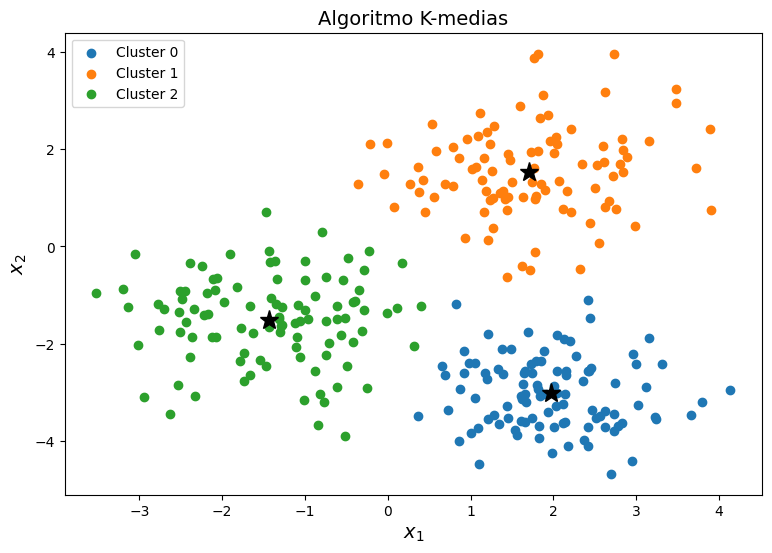

In [ ]:
# Representación gráfica de la solución
import matplotlib.pyplot as plt

# Obtenemos de Spark los datos del PCA (cuidado con no desbordar la memoria)
collected_data = df.select("features").collect()
collected_data = np.array(collected_data).reshape(-1,2)

plt.figure(figsize=(9, 6))
for k in np.unique(pred):
  plt.scatter(collected_data[pred==k, 0], collected_data[pred==k, 1], label="Cluster {}".format(k))
  #plt.scatter(X[pred==k, 0], X[pred==k, 1], label="Cluster {}".format(k))
  plt.plot(centroides[k][0], centroides[k][1], 'k*', markersize=14) # Dibujamos los centroides

plt.title("Algoritmo K-medias", fontsize=14)
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14)
plt.legend()
plt.show()